In [198]:
from utils import (adstock,decomposition,create_transformed_tables, calc_roi, decomposition_linear, merge_rois_with_percent_change)
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
# Display the full statsmodels summary output as preformatted text to avoid truncation in Jupyter
from IPython.display import display, Markdown

In [199]:
# Load data from the 'dataset' sheet, range B6:CY266, with 'Date' as the date column
df_data = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='DataSet',
    usecols='B:DA',
    skiprows=5,
    nrows=261,
    parse_dates=['Date']
).set_index('Date')

# Add a random number column
df_data['random'] = np.random.rand(len(df_data))


df_var_spec_all = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='EqnSpec',
    usecols='A:h',
) #.set_index('variable')

### Create Log-Linear Model


In [200]:
df_var_spec = df_var_spec_all.copy()
df_var_spec = df_var_spec.rename(columns={'beta_log': 'beta'})
df_var_spec = df_var_spec[df_var_spec['beta'].notnull()].copy()
df_var_spec = df_var_spec.drop(columns=['beta_add'])
df_var_spec['log'] = df_var_spec['log'] == 1
df_var_spec


,variable,beta,carryover,log,group,decomp_ref,spend_variable
0,c,1.200000e+01,NaN,False,base,NaN,NaN
2,d_jan,-1.500000e-01,NaN,False,base,NaN,-240000
3,d_feb,-1.000000e-01,NaN,False,base,NaN,-160000
4,d_mar,8.000000e-02,NaN,False,base,NaN,128000
5,d_apr,1.000000e-01,NaN,False,base,NaN,160000
6,d_may,1.000000e-01,NaN,False,base,NaN,160000
10,d_sep,5.000000e-02,NaN,False,base,NaN,80000
11,d_oct,1.000000e-01,NaN,False,base,NaN,160000
12,d_nov,1.500000e-01,NaN,False,base,NaN,240000
13,d_dec,-2.000000e-01,NaN,False,base,NaN,-320000


In [201]:
sigma = 0.05
df_data['error'] = scipy.stats.norm.ppf(df_data['random'], loc=0, scale=sigma)

In [202]:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec,True)

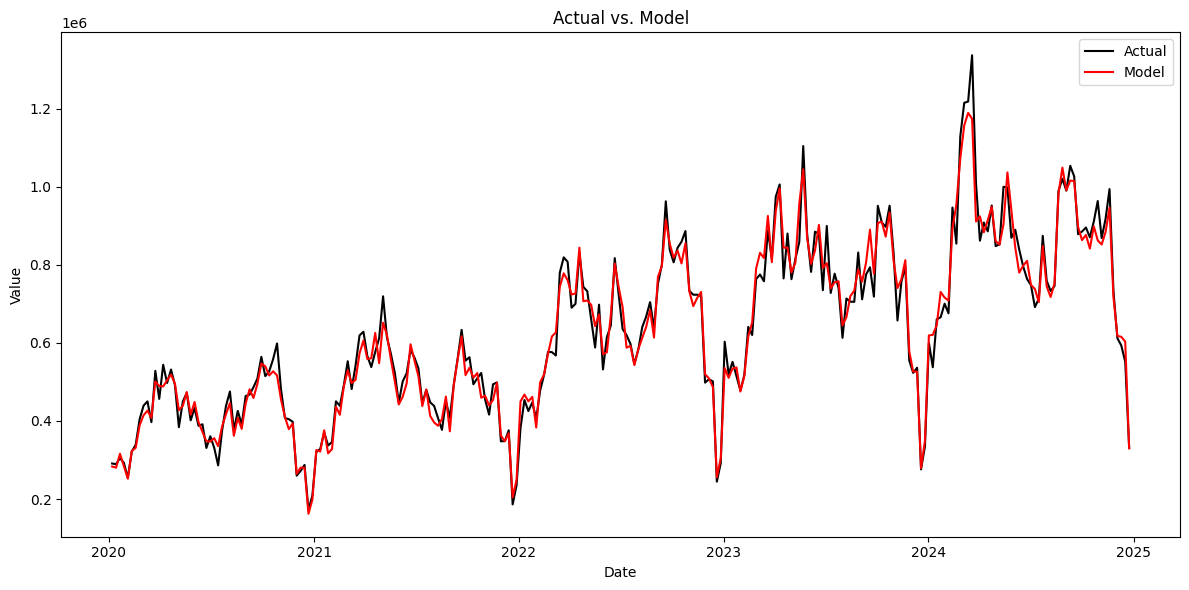

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_values.index, df_values['actual'], label='Actual', color='black')
plt.plot(df_values.index, df_values['model'], label='Model', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Model')
plt.legend()
plt.tight_layout()
plt.show()

In [204]:
df_decomp_vol = decomposition(df_var_spec,df_values)
price_col = 'price_se_xf'
df_decomp_val = df_decomp_vol.multiply(df_data[price_col], axis=0)

Check passed: True
Group sum check passed: True
Check passed: True


In [205]:
df_rois = calc_roi(df_decomp_val, df_var_spec, df_data)

In [206]:
# Interactive stacked area chart of all variables in df_decomp_vol except model, model_og, diff using plotly
import plotly.graph_objects as go
exclude_cols = ['model', 'model_og', 'diff']
area_cols = [col for col in df_decomp_vol.columns if col not in exclude_cols]
fig = go.Figure()
for col in area_cols:
    fig.add_trace(go.Scatter(x=df_decomp_vol.index, y=df_decomp_vol[col], mode='lines', stackgroup='one', name=col))
fig.update_layout(title='Stacked Area Chart of Variable Contributions (Interactive)',
                  xaxis_title='Date', yaxis_title='Contribution',
                  legend_title='Variable',
                  hovermode='x unified',
                  height=600, width=1000)
fig.show()

In [207]:
regression_vars = list(df_trans.columns)

import statsmodels.api as sm
X = df_trans[regression_vars].fillna(0)
y = np.log(df_values['actual'])
model = sm.OLS(y, X).fit()

summary_text = model.summary().as_text()
display(Markdown(f'```{summary_text}```'))

```                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     375.9
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          4.58e-179
Time:                        12:32:54   Log-Likelihood:                 412.63
No. Observations:                 260   AIC:                            -755.3
Df Residuals:                     225   BIC:                            -630.6
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c                      13.1631      1.204     10.929      0.000      10.790      15.536
d_jan                  -0.1716      0.016    -10.501      0.000      -0.204      -0.139
d_feb                  -0.0969      0.017     -5.857      0.000      -0.130      -0.064
d_mar                   0.0885      0.016      5.424      0.000       0.056       0.121
d_apr                   0.0907      0.020      4.600      0.000       0.052       0.130
d_may                   0.1010      0.016      6.353      0.000       0.070       0.132
d_sep                   0.0430      0.016      2.677      0.008       0.011       0.075
d_oct                   0.1142      0.020      5.842      0.000       0.076       0.153
d_nov                   0.1574      0.016     10.076      0.000       0.127       0.188
d_dec                  -0.2194      0.018    -12.269      0.000      -0.255      -0.184
school_easter          -0.0546      0.032     -1.683      0.094      -0.119       0.009
school_ht_feb          -0.0774      0.040     -1.937      0.054      -0.156       0.001
school_ht_may          -0.0547      0.036     -1.512      0.132      -0.126       0.017
school_ht_oct          -0.0088      0.040     -0.219      0.826      -0.088       0.071
payday_25               0.0692      0.009      8.087      0.000       0.052       0.086
bh_ny                  -0.5045      0.029    -17.397      0.000      -0.562      -0.447
bh_xmas                -0.6935      0.029    -23.620      0.000      -0.751      -0.636
day_valentine           0.2446      0.009     28.401      0.000       0.228       0.262
ww_nat_dlta_maxtemp     0.0107      0.002      5.391      0.000       0.007       0.015
ww_nat_dlta_rain       -0.0229      0.003     -7.986      0.000      -0.028      -0.017
ww_nat_dlta_sun         0.0088      0.003      2.574      0.011       0.002       0.015
rsi_nfood_vol_sa        0.7126      0.263      2.710      0.007       0.194       1.231
dist_xf                 0.7271      0.225      3.235      0.001       0.284       1.170
price_se_xf            -1.7225      0.163    -10.567      0.000      -2.044      -1.401
prom_tft                0.1451      0.010     14.565      0.000       0.125       0.165
pos_fsdu                0.1156      0.012      9.538      0.000       0.092       0.139
m_wow_tv             1.638e-07   5.73e-08      2.859      0.005    5.09e-08    2.77e-07
m_wow_olv            2.884e-07   2.15e-07      1.344      0.180   -1.35e-07    7.11e-07
m_wow_social         -6.34e-07   6.91e-07     -0.918      0.360      -2e-06    7.27e-07
m_amaze_tot          8.253e-08   1.81e-08      4.562      0.000    4.69e-08    1.18e-07
m_celeb_tv           1.241e-07   5.95e-08      2.087      0.038    6.93e-09    2.41e-07
m_celeb_outdoor      2.417e-08   8.13e-08      0.297      0.767   -1.36e-07    1.84e-07
m_celeb_display      5.224e-07   3.32e-07      1.574      0.117   -1.32e-07    1.18e-06
comp_lor_tot        -3.539e-08   2.35e-08     -1.506      0.133   -8.17e-08    1.09e-08
comp_no7_tot        -2.434e-08   2.48e-08     -0.983      0.327   -7.31e-08    2.44e-08
==============================================================================
Omnibus:                        4.078   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.731
Skew:                          -0.258   Prob(JB):                        0.155
Kurtosis:                       3.281   Cond. No.                     1.48e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+08. This might indicate that there are
strong multicollinearity or other numerical problems.```

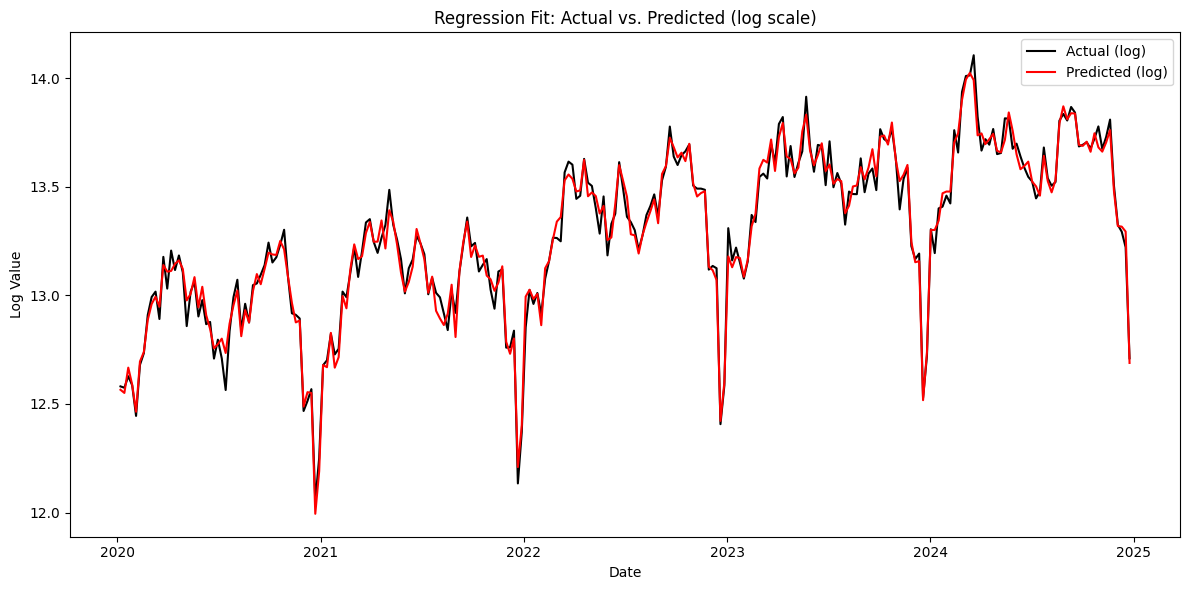

In [208]:
# Chart the fit of the regression: actual vs. predicted
y_pred = model.predict(sm.add_constant(df_trans[regression_vars].fillna(0)))
plt.figure(figsize=(12, 6))
plt.plot(df_values.index, y, label='Actual (log)', color='black')
plt.plot(df_values.index, y_pred, label='Predicted (log)', color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Log Value')
plt.title('Regression Fit: Actual vs. Predicted (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [209]:
# coefs = pd.Series(model.params, index=model.params.index)
df_var_spec_est = df_var_spec.copy()
df_var_spec_est['beta'] = df_var_spec_est['variable'].map(model.params)

df_trans_est, df_values_est = create_transformed_tables(df_data, df_var_spec_est, True)
df_decomp_vol_est = decomposition(df_var_spec_est,df_values_est)
df_decomp_val_est = df_decomp_vol_est.multiply(df_data[price_col], axis=0)
df_rois_est = calc_roi(df_decomp_val_est, df_var_spec_est, df_data)


Check passed: True
Group sum check passed: True
Check passed: True


In [210]:
# Use the function and keep the same downstream variable name
df_rois_merged = merge_rois_with_percent_change(df_rois, df_rois_est)
df_rois_merged

,variable,value,spend_sum,roi,roi (est),% change (est/actual)
0,m_wow_tv,"4,471,876","2,699,491",1.66,2.33,40.36%
1,m_wow_olv,"1,923,657","947,317",2.03,3.02,48.77%
2,m_wow_social,"497,480","121,919",4.08,-6.51,-259.56%
3,m_amaze_tot,"10,117,907","7,929,905",1.28,1.18,-7.81%
4,m_celeb_tv,"8,590,703","2,828,021",3.04,3.20,5.26%
5,m_celeb_outdoor,"3,712,733","1,290,619",2.88,0.59,-79.51%
6,m_celeb_display,"3,941,598","1,586,718",2.48,6.52,162.90%
7,Total,"33,255,954","17,403,991",1.91,2.18,14.14%


In [ ]:
# Save key DataFrames as CSVs in the results folder
import os
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

df_data.to_csv(os.path.join(results_dir, 'data.csv'))
df_var_spec.to_csv(os.path.join(results_dir, 'var_spec.csv'), index=False)
df_var_spec_est.to_csv(os.path.join(results_dir, 'var_spec_est.csv'), index=False)
df_decomp_vol.to_csv(os.path.join(results_dir, 'decomp.csv'))
df_decomp_vol_est.to_csv(os.path.join(results_dir, 'decomp_est.csv'))
df_rois_merged.to_csv(os.path.join(results_dir, 'Rois.csv'), index=False)

### Additive model


In [227]:
## change svol_xf to svol_xf_add
df_data['svol_xf'] = df_data['svol_xf_add']

df_var_spec = df_var_spec_all.copy()
df_var_spec = df_var_spec.rename(columns={'beta_add': 'beta'})
df_var_spec = df_var_spec[df_var_spec['beta'].notnull() & df_var_spec['beta']!=0].copy()
df_var_spec = df_var_spec.drop(columns=['beta_log'])
df_var_spec['log'] = None
df_var_spec


,variable,beta,carryover,log,group,decomp_ref,spend_variable
0,c,500000.00,NaN,None,base,NaN,NaN
2,d_jan,-120000.00,NaN,None,base,NaN,-240000
3,d_feb,-80000.00,NaN,None,base,NaN,-160000
4,d_mar,64000.00,NaN,None,base,NaN,128000
5,d_apr,80000.00,NaN,None,base,NaN,160000
6,d_may,80000.00,NaN,None,base,NaN,160000
10,d_sep,40000.00,NaN,None,base,NaN,80000
11,d_oct,80000.00,NaN,None,base,NaN,160000
12,d_nov,120000.00,NaN,None,base,NaN,240000
13,d_dec,-160000.00,NaN,None,base,NaN,-320000


In [228]:
df_data.head()
sigma = 0.03
df_data['error'] = scipy.stats.norm.ppf(df_data['random'], loc=0, scale=sigma)
# df_data['error']=0

In [229]:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec,False)

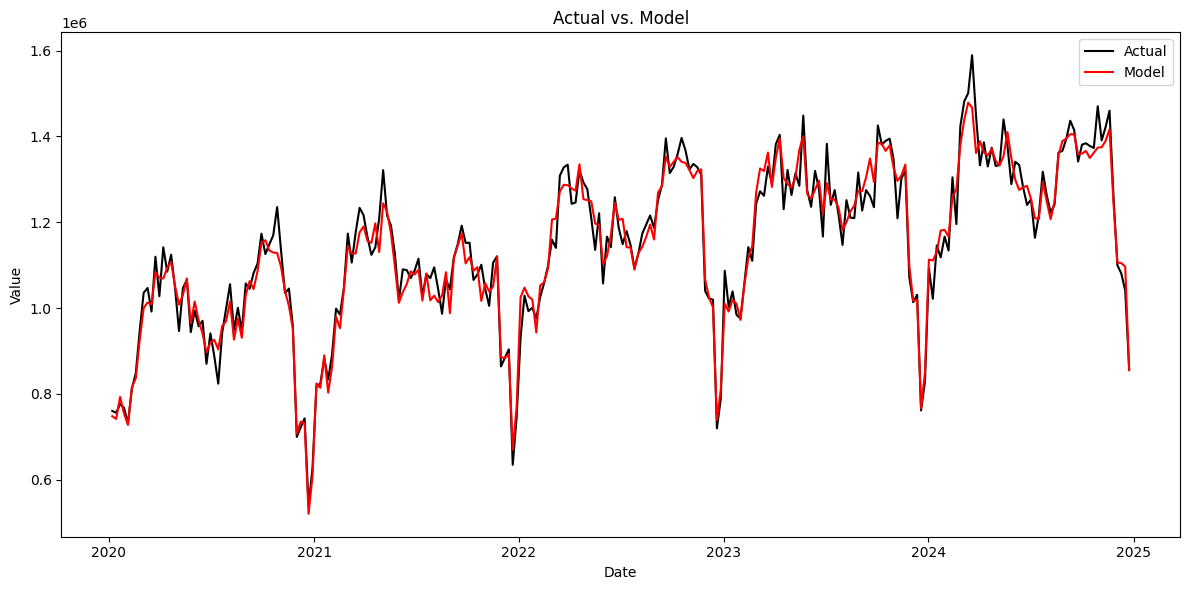

In [230]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_values.index, df_values['actual'], label='Actual', color='black')
plt.plot(df_values.index, df_values['model'], label='Model', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Model')
plt.legend()
plt.tight_layout()
plt.show()

In [231]:
df_decomp_vol = decomposition_linear(df_var_spec,df_values)
price_col = 'price_se_xf'
df_decomp_val = df_decomp_vol.multiply(df_data[price_col], axis=0)
df_rois = calc_roi(df_decomp_val, df_var_spec, df_data)

Check passed: True
Group sum check passed: True


In [232]:
# Interactive stacked area chart of all variables in df_decomp_vol except model, model_og, diff using plotly
import plotly.graph_objects as go
exclude_cols = ['model', 'model_og', 'diff']
area_cols = [col for col in df_decomp_vol.columns if col not in exclude_cols]
fig = go.Figure()
for col in area_cols:
    fig.add_trace(go.Scatter(x=df_decomp_vol.index, y=df_decomp_vol[col], mode='lines', stackgroup='one', name=col))
fig.update_layout(title='Stacked Area Chart of Variable Contributions (Interactive)',
                  xaxis_title='Date', yaxis_title='Contribution',
                  legend_title='Variable',
                  hovermode='x unified',
                  height=600, width=1000)
fig.show()

In [233]:
regression_vars = list(df_trans.columns)

import statsmodels.api as sm
X = df_trans[regression_vars].fillna(0)
y = df_values['actual']
model = sm.OLS(y, X).fit()

summary_text = model.summary().as_text()
display(Markdown(f'```{summary_text}```'))

```                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     190.4
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          8.95e-147
Time:                        12:54:15   Log-Likelihood:                -3084.9
No. Observations:                 260   AIC:                             6240.
Df Residuals:                     225   BIC:                             6364.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c                    8.124e+05   2.26e+05      3.595      0.000    3.67e+05    1.26e+06
d_jan               -1.339e+05   1.14e+04    -11.787      0.000   -1.56e+05   -1.11e+05
d_feb               -8.002e+04   1.15e+04     -6.967      0.000   -1.03e+05   -5.74e+04
d_mar                7.139e+04   1.13e+04      6.326      0.000    4.92e+04    9.36e+04
d_apr                7.343e+04   1.37e+04      5.362      0.000    4.64e+04       1e+05
d_may                8.352e+04   1.11e+04      7.554      0.000    6.17e+04    1.05e+05
d_sep                3.142e+04   1.12e+04      2.811      0.005    9396.846    5.35e+04
d_oct                9.138e+04   1.36e+04      6.728      0.000    6.46e+04    1.18e+05
d_nov                1.275e+05   1.09e+04     11.749      0.000    1.06e+05    1.49e+05
d_dec               -1.716e+05   1.24e+04    -13.804      0.000   -1.96e+05   -1.47e+05
school_easter       -4.358e+04   2.26e+04     -1.932      0.055    -8.8e+04     860.878
school_ht_feb       -6.053e+04   2.78e+04     -2.180      0.030   -1.15e+05   -5813.167
school_ht_may       -4.554e+04   2.51e+04     -1.811      0.071   -9.51e+04    4001.723
school_ht_oct       -1.522e+04    2.8e+04     -0.543      0.587   -7.04e+04       4e+04
payday_25            2.533e+04   5945.970      4.260      0.000    1.36e+04     3.7e+04
bh_ny               -2.016e+05   2.02e+04     -9.999      0.000   -2.41e+05   -1.62e+05
bh_xmas             -2.742e+05   2.04e+04    -13.433      0.000   -3.14e+05   -2.34e+05
day_valentine        9.749e+04   5876.345     16.591      0.000    8.59e+04    1.09e+05
ww_nat_dlta_maxtemp  4423.6577   1381.958      3.201      0.002    1700.421    7146.894
ww_nat_dlta_rain    -1.026e+04   1989.396     -5.157      0.000   -1.42e+04   -6338.984
ww_nat_dlta_sun      2869.8115   2368.714      1.212      0.227   -1797.889    7537.512
rsi_nfood_vol_sa     8310.8767   1664.440      4.993      0.000    5030.992    1.16e+04
dist_xf              2.809e+04   2.01e+05      0.140      0.889   -3.69e+05    4.25e+05
price_se_xf         -9.746e+04   1.19e+04     -8.193      0.000   -1.21e+05    -7.4e+04
prom_tft             5.733e+04   6920.716      8.283      0.000    4.37e+04     7.1e+04
pos_fsdu             5.323e+04   8425.850      6.318      0.000    3.66e+04    6.98e+04
m_wow_tv                0.1285      0.040      3.243      0.001       0.050       0.207
m_wow_olv               0.1847      0.149      1.240      0.216      -0.109       0.478
m_wow_social           -0.7232      0.478     -1.512      0.132      -1.666       0.219
m_amaze_tot             0.1006      0.013      8.042      0.000       0.076       0.125
m_celeb_tv              0.1061      0.041      2.568      0.011       0.025       0.188
m_celeb_outdoor         0.0172      0.057      0.304      0.761      -0.094       0.129
m_celeb_display         0.3642      0.231      1.576      0.116      -0.091       0.820
comp_lor_tot           -0.0620      0.016     -3.792      0.000      -0.094      -0.030
comp_no7_tot           -0.0545      0.017     -3.166      0.002      -0.088      -0.021
==============================================================================
Omnibus:                        1.013   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.730
Skew:                          -0.008   Prob(JB):                        0.694
Kurtosis:                       3.259   Cond. No.                     4.73e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.73e+07. This might indicate that there are
strong multicollinearity or other numerical problems.```

In [234]:
# coefs = pd.Series(model.params, index=model.params.index)
df_var_spec_est = df_var_spec.copy()
df_var_spec_est['beta'] = df_var_spec_est['variable'].map(model.params)

df_trans_est, df_values_est = create_transformed_tables(df_data, df_var_spec_est, False)

df_decomp_vol_est = decomposition_linear(df_var_spec_est,df_values_est)
df_decomp_val_est = df_decomp_vol_est.multiply(df_data[price_col], axis=0)
df_rois_est = calc_roi(df_decomp_val_est, df_var_spec_est, df_data)


Check passed: True
Group sum check passed: True


In [235]:
# Use the function and keep the same downstream variable name
df_rois_merged = merge_rois_with_percent_change(df_rois, df_rois_est)
df_rois_merged

,variable,value,spend_sum,roi,roi (est),% change (est/actual)
0,m_wow_tv,"8,153,785","2,699,491",3.02,3.88,28.48%
1,m_wow_olv,"2,121,312","947,317",2.24,4.14,84.82%
2,m_wow_social,"213,268","121,919",1.75,-12.65,-822.86%
3,m_amaze_tot,"25,532,763","7,929,905",3.22,3.24,0.62%
4,m_celeb_tv,"9,193,975","2,828,021",3.25,3.45,6.15%
5,m_celeb_outdoor,"4,194,756","1,290,619",3.25,0.56,-82.77%
6,m_celeb_display,"2,606,237","1,586,718",1.64,5.98,264.63%
7,Total,"52,016,095","17,403,991",2.99,3.36,12.37%


In [237]:
# Save key DataFrames as CSVs in the results folder
import os
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)


suffix= '_add'
df_data.to_csv(os.path.join(results_dir, 'data' + suffix + '.csv'))
df_var_spec.to_csv(os.path.join(results_dir, 'var_spec' + suffix + '.csv'), index=False)
df_var_spec_est.to_csv(os.path.join(results_dir, 'var_spec_est' + suffix + '.csv'), index=False)
df_decomp_vol.to_csv(os.path.join(results_dir, 'decomp' + suffix + '.csv'))
df_decomp_vol_est.to_csv(os.path.join(results_dir, 'decomp_est' + suffix + '.csv'))
df_rois_merged.to_csv(os.path.join(results_dir, 'Rois' + suffix + '.csv'), index=False)